# 🚀 Credit Risk Portfolio: Vintage Analysis & Observe Window Optimization


## 📝 Introduction
This project implements Vintage Analysis-a powerful cohort-based analytical technique-to decode credit risk behavior over time.

In credit risk management, a static "snapshot" of a portfolio can be misleading, as it fails to account for the maturity of loans. This project tracks the cumulative delinquency rates of specific cohorts (grouped by disbursement month) relative to their Months on Books (MOB). By analyzing these "vintages," we can observe the maturation of risk and identify the exact point where a customer's credit quality fully reveals itself. This analysis serves as the fundamental cornerstone for establishing an accurate Labeling (Good/Bad) logic for downstream Credit Scoring models.

## 🎯 Project Objectives
The project is structured to achieve three core strategic objectives:

1. Identify the Optimal Observe Window
Objective: Locate the "Saturation Point" where cumulative bad rates stabilize and cease to rise significantly.

- Expected Outcome: Validating 20 months (Window = 20) as the standard observation benchmark. This ensures that only accounts with sufficient history are used for risk assessment, effectively filtering out "immature" data noise.

2. Standardize "Bad" Definition Logic
Objective: Analyze the speed and magnitude of risk emergence across different delinquency thresholds (ranging from 30 DPD to 150+ DPD).

- Expected Outcome: Clarifying the temporal logic behind high-severity delinquency (e.g., 150+ DPD requires at least 5 MOB to appear). This justifies the necessity of a long observation window to capture severe credit events.

3. Data Refinement for Model Integrity
Objective: Establish a rigorous data filtering pipeline based on time-on-books.

- Expected Outcome: Eliminating artificial volatility caused by newly disbursed accounts. By ensuring the training set only includes customers who have faced the "test of time," we enhance the reliability and predictive power of the final scoring model.

In [1]:
import pandas as pd
import numpy as np

df_credit = pd.read_csv('/content/credit_record.csv')
df_credit.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [2]:
pivot_tb = df_credit.groupby('ID')['MONTHS_BALANCE'].agg(['min', 'max'])
pivot_tb['window'] = pivot_tb['max'] - pivot_tb['min']
pivot_tb.reset_index(inplace = True)
print(pivot_tb.head(5))

df_credit = pd.merge(df_credit, pivot_tb, on = 'ID', how = 'left')
df_credit['MOB'] = df_credit['MONTHS_BALANCE'] - df_credit['min']
df_credit = df_credit[df_credit['window'] > 20]

df_credit['status'] = np.where(df_credit['STATUS'].isin(['2', '3', '4', '5']), 1, 0)
df_credit.sort_values(by = ['ID','MOB'], inplace = True)
print(df_credit.head(5))

        ID  min  max  window
0  5001711   -3    0       3
1  5001712  -18    0      18
2  5001713  -21    0      21
3  5001714  -14    0      14
4  5001715  -59    0      59
         ID  MONTHS_BALANCE STATUS  min  max  window  MOB  status
44  5001713             -21      X  -21    0      21    0       0
43  5001713             -20      X  -21    0      21    1       0
42  5001713             -19      X  -21    0      21    2       0
41  5001713             -18      X  -21    0      21    3       0
40  5001713             -17      X  -21    0      21    4       0


In [3]:
pivot_tb

,ID,min,max,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [4]:
denominator = pivot_tb.groupby(['min']).agg({'ID': ['count']})
denominator.reset_index(inplace = True)
denominator.columns = ['min','sta_sum']
denominator

,min,sta_sum
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [5]:
# Check: pivot_tb['ID'][(pivot_tb['min'] == -60)]

In [6]:
vintage = df_credit.groupby(['min','MOB']).agg({'ID': ['count']})
vintage.reset_index(inplace = True)
vintage.columns = ['min','MOB','due_count']
vintage['due_count'] = np.nan
vintage = vintage[['min','MOB','due_count']]
vintage

,min,MOB,due_count
0,-60,0,NaN
1,-60,1,NaN
2,-60,2,NaN
3,-60,3,NaN
4,-60,4,NaN
...,...,...,...
1655,-21,17,NaN
1656,-21,18,NaN
1657,-21,19,NaN
1658,-21,20,NaN


In [7]:
# Join sta_sum column to vintage table
vintage = pd.merge(vintage, denominator, on = ['min'], how = 'left')
vintage

,min,MOB,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


# Create a table containing overdue loan records

In [8]:
# for r in range(-60,1):
#   row = []
#   for c in range(0,61):
#     overdue = list(df_credit[df_credit['status']==1 & (df_credit['MOB']==c) & (df_credit['min']==r)]['ID'])
#     row.extend(overdue)
#     vintage.loc[(vintage['MOB']==c) & (vintage['min']==r), 'due_count'] = len(set(overdue))
# vintage

In [9]:
# 1. Find the first month (MOB) that each ID has a debt (status == 1) in each 'min' group.
first_overdue = (df_credit[df_credit['status'] == 1]
                 .groupby(['ID', 'min'])['MOB']
                 .min()
                 .reset_index())

# 2. Count the number of new IDs that have incurred debt at each (min, MOB)
new_entries = (first_overdue.groupby(['min', 'MOB'])
               .size()
               .reset_index(name='new_due_count'))

# 3. Combine into a vintage table and calculate the cumulative sum (cumsum) for each 'min' group.
vintage = vintage.merge(new_entries, on=['min', 'MOB'], how='left')
vintage['new_due_count'] = vintage['new_due_count'].fillna(0)

# Calculate the cumulative total to obtain the number of unique IDs 'ever overdue' up to that point.
vintage['due_count'] = vintage.groupby('min')['new_due_count'].cumsum()

# 4. Convert to float and delete the auxiliary column
vintage['due_count'] = vintage['due_count'].astype(float)
vintage = vintage.drop(columns=['new_due_count'])

# 5. Calculate the cumulative percentage of customers with bad debt
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum']
vintage

,min,MOB,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [10]:
vintage_wide = vintage.pivot(index='min', columns='MOB', values='sta_rate')
vintage_wide

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
min,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.00000,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,...,0.028398,0.028398,0.028398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52,0.00000,0.000000,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,0.016275,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


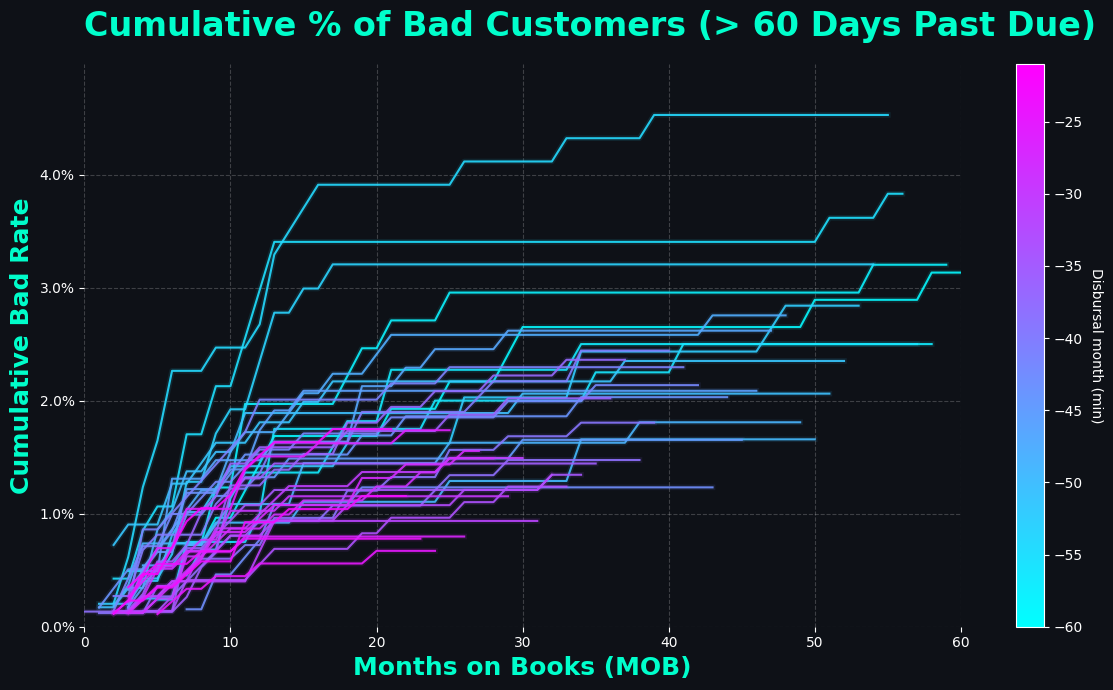

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
fig.patch.set_facecolor('#0E1117')
ax.set_facecolor('#0E1117')

vintage_plot = vintage_wide.replace(0, np.nan)

# Old files will be cyan, new files will gradually change to magenta/pink.
colors = sns.color_palette("cool", len(vintage_plot))

for i, (index, row) in enumerate(vintage_plot.iterrows()):
    ax.plot(row.index, row.values, color=colors[i], alpha=0.1, linewidth=4)
    ax.plot(row.index, row.values, color=colors[i], alpha=0.9, linewidth=1.5)

ax.set_title('Cumulative % of Bad Customers (> 60 Days Past Due)',
             fontsize=24, fontweight='bold', pad=20, loc='left', color='#00FFCC')
ax.set_xlabel('Months on Books (MOB)', fontsize=18, fontweight='bold', color='#00FFCC')
ax.set_ylabel('Cumulative Bad Rate', fontsize=18, fontweight='bold', color='#00FFCC')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))

ax.set_xlim(0, 60)
ax.set_ylim(0, vintage['sta_rate'].max() * 1.1)

ax.grid(True, linestyle='--', alpha=0.2, color='#FFFFFF')

sm = plt.cm.ScalarMappable(cmap="cool", norm=plt.Normalize(vmin=vintage['min'].min(), vmax=vintage['min'].max()))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Disbursal month (min)', rotation=270, labelpad=15, color='#FFFFFF')
cbar.ax.yaxis.set_tick_params(color='#FFFFFF')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#FFFFFF')

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

It is easy to see the trend: recent customer groups have higher or lower risk than older groups.

# Observe Window Analysis

In [12]:
def calculate_observe(df_credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    df_credit['status'] = 0
    exec(command)
    # df_credit.loc[(df_credit['STATUS'] == '4' )| (df_credit['STATUS'] == '5'), 'status'] = 1
    df_credit['MOB'] = df_credit['MONTHS_BALANCE'] - df_credit['min']
    minagg = df_credit[df_credit['status'] == 1].groupby('ID')['MOB'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'MOB':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['MOB']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['MOB'] == i, 'rate'] = len(set(lst)) / id_sum
    return obslst['rate']

command = "df_credit.loc[(df_credit['STATUS'] == '0') | (df_credit['STATUS'] == '1') | (df_credit['STATUS'] == '2') | (df_credit['STATUS'] == '3' )| (df_credit['STATUS'] == '4' )| (df_credit['STATUS'] == '5'), 'status'] = 1"
morethan1 = calculate_observe(df_credit, command)
command = "df_credit.loc[(df_credit['STATUS'] == '1') | (df_credit['STATUS'] == '2') | (df_credit['STATUS'] == '3' )| (df_credit['STATUS'] == '4' )| (df_credit['STATUS'] == '5'), 'status'] = 1"
morethan30 = calculate_observe(df_credit, command)
command = "df_credit.loc[(df_credit['STATUS'] == '2') | (df_credit['STATUS'] == '3' )| (df_credit['STATUS'] == '4' )| (df_credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(df_credit, command)
command = "df_credit.loc[(df_credit['STATUS'] == '3' )| (df_credit['STATUS'] == '4' )| (df_credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(df_credit, command)
command = "df_credit.loc[(df_credit['STATUS'] == '4' )| (df_credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(df_credit, command)
command = "df_credit.loc[(df_credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(df_credit, command)

In [13]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

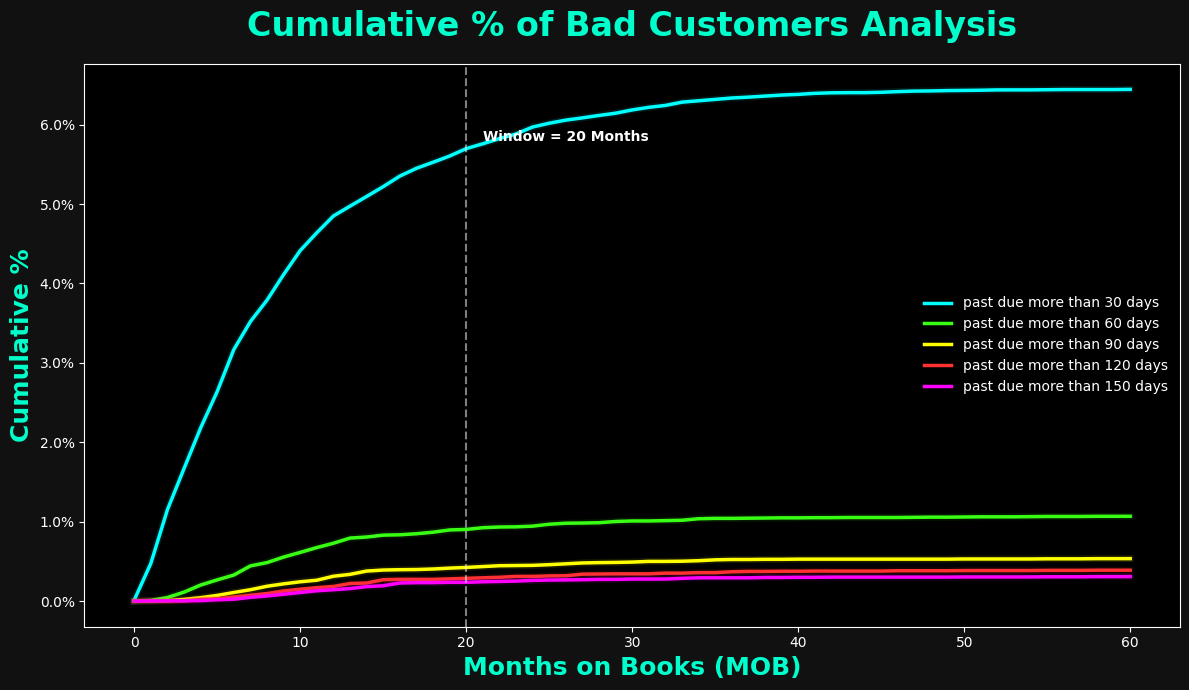

In [14]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('#111111')

neon_palette = ['#00FFFF', '#39FF14', '#FFFF00', '#FF3131', '#FF00FF']

for i, col in enumerate(obslst.columns):
    ax.plot(obslst.index, obslst[col], color=neon_palette[i], linewidth=5, alpha=0.1)
    ax.plot(obslst.index, obslst[col], label=col, color=neon_palette[i], linewidth=2.5)

ax.axvline(x=20, color='#FFFFFF', linestyle='--', alpha=0.5)
ax.text(21, obslst.max().max() * 0.9, 'Window = 20 Months', color='white', fontweight='bold')

ax.set_title('Cumulative % of Bad Customers Analysis', fontweight='bold',fontsize=24, color='#00FFCC', pad=20)
ax.set_xlabel('Months on Books (MOB)', fontweight='bold',fontsize=18, color='#00FFCC')
ax.set_ylabel('Cumulative %', fontweight='bold',fontsize=18, color='#00FFCC')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
ax.legend(frameon=False, loc='center right')

plt.tight_layout()
plt.show()

# Analysis of Bad Debt Customer Accumulation Chart

1. Risk exposure trends over time (MOB):

- Early exposure phase (MOB 1 - 10): The overdue debt ratio grows most rapidly in the short-term debt group (Status >= 1, > 30 days). This indicates that risk often emerges very quickly immediately after disbursement.

- Saturation phase (After MOB 20): The bad debt curves (especially the heavy debt group > 60 days) tend to flatten. This proves that most customers who intend to default or become insolvent have already exhibited such behavior within the first 20 months.

2. Polarization between debt groups (DPD Buckets):

- Short-term debt group (> 30 days): Has a significantly high ratio and appears immediately. The logic here is due to technical risks: customers forget payment schedules, encounter payment channel issues, or experience temporary cash flow difficulties. This group carries a lot of “noise” and often has a high self-cure rate.

- Long-term debt group (> 60 to > 150 days):

  - Time lag: The > 150-day debt line only starts to appear from MOB 5 because it takes at least 5 consecutive months of non-payment to reach this status.

  - Low & stable ratio: The large gap between the 30-day line and the other lines indicates that collections are operating effectively, successfully preventing customers from rolling into heavier debt levels.

3. Significance for determining the Observation Window:

- Consistency: Using the Month (MOB) unit helps synchronize different debt criteria on a single time scale.

- Cut-off selection: The 20-month mark (Window = 20) is chosen as the standard because it covers the majority of actual bad debt cases.

- Data processing strategy: Records with a system existence time of less than 20 months need to be excluded from the model training sample to avoid bias, as they have not undergone sufficient “time testing” to confirm whether they are Good or Bad customers.